In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils




In [ ]:
!git clone https://github.com/Ashish-Arya-CS/Coursera-Content.git

Cloning into 'Coursera-Content'...
remote: Enumerating objects: 3049, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3049 (delta 1), reused 6 (delta 1), pack-reused 3043
Receiving objects: 100% (3049/3049), 79.25 MiB | 26.60 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (3287/3287), done.


In [ ]:
os.mkdir('/content/Crop-Brain-MRI')
os.mkdir('/content/Crop-Brain-MRI/glioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/meningioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/pituitary_tumor')
os.mkdir('/content/Crop-Brain-MRI/no_tumor')

In [ ]:
os.mkdir('/content/Test-Data')
os.mkdir('/content/Test-Data/glioma_tumor')
os.mkdir('/content/Test-Data/meningioma_tumor')
os.mkdir('/content/Test-Data/pituitary_tumor')
os.mkdir('/content/Test-Data/no_tumor')

In [ ]:
train_dir = '/content/tumor_dataset/Brain-MRI/Training/'
test_dir = '/content/tumor_dataset/Brain-MRI/Testing/'

In [ ]:
classes = os.listdir('/content/tumor_dataset/Brain-MRI/Training')
classes

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

In [ ]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))


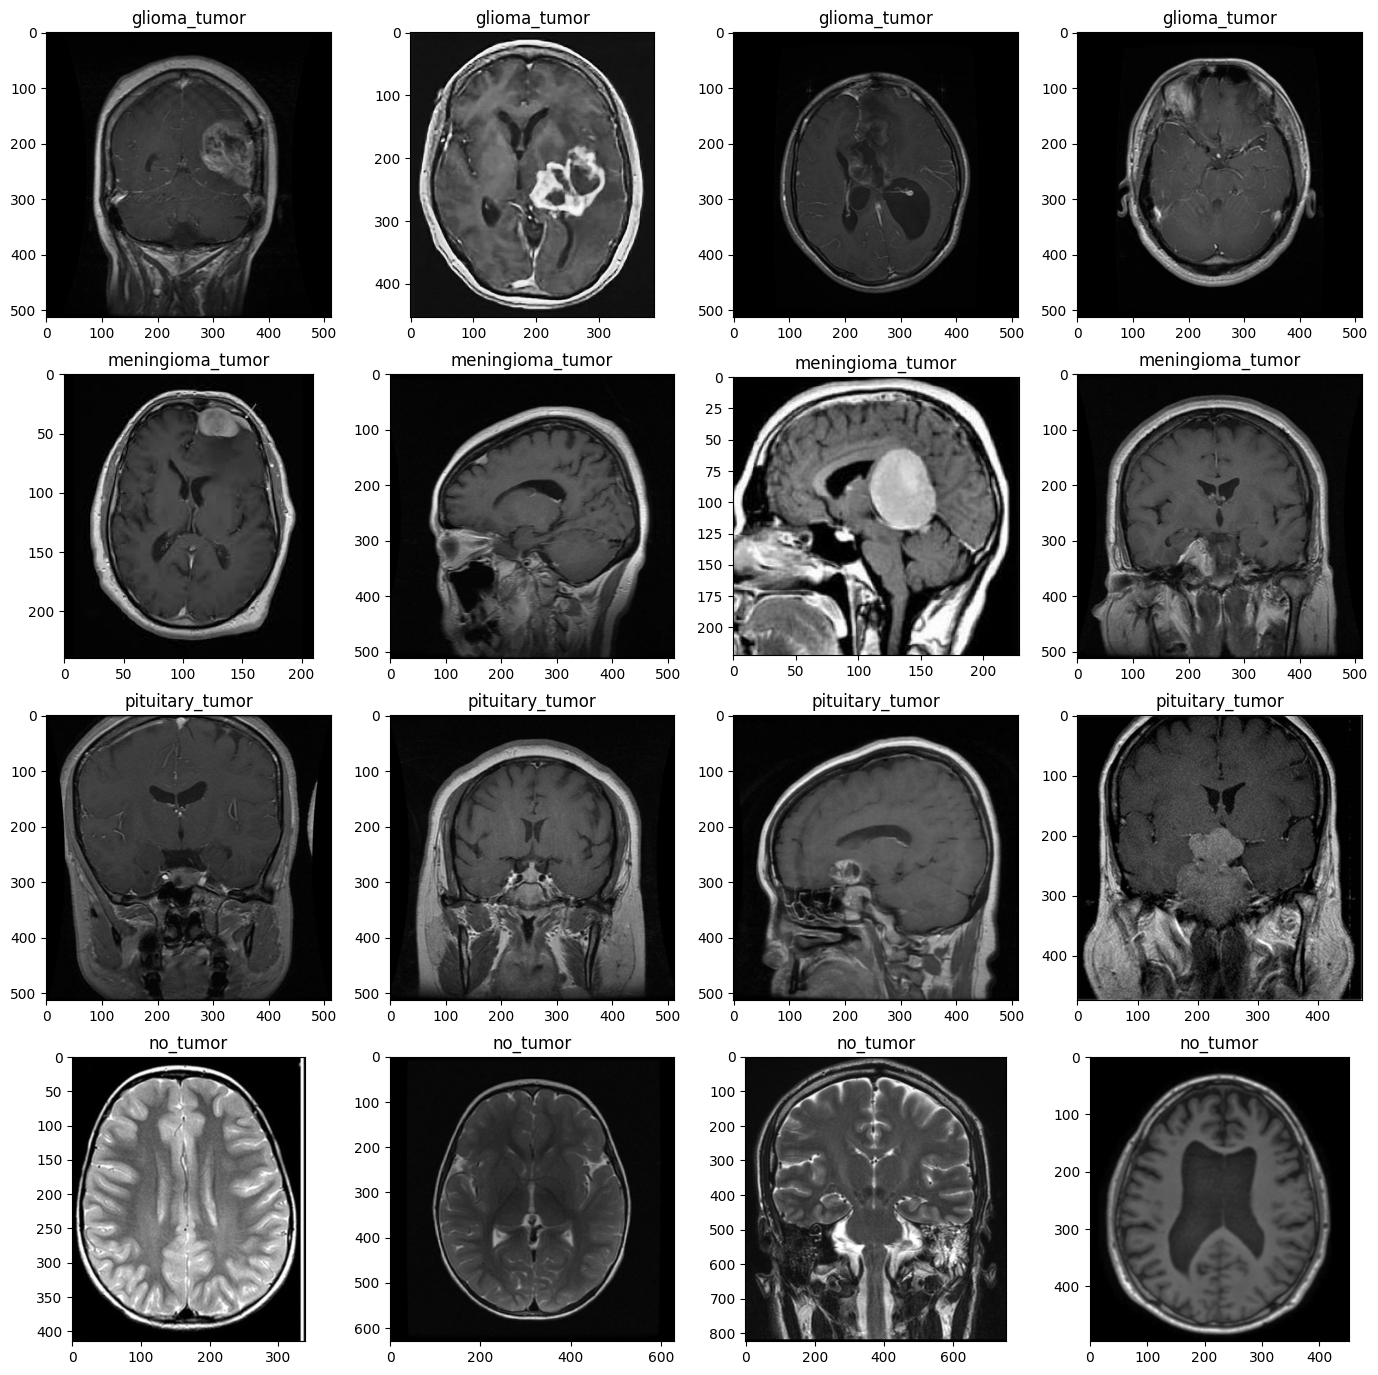

In [ ]:
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [ ]:
No_images_per_class = []
Class_name = []

for i in os.listdir('/content/tumor_dataset/Brain-MRI/Training'):
  train_class = os.listdir(os.path.join('/content/tumor_dataset/Brain-MRI/Training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in glioma_tumor = 926 

Number of images in meningioma_tumor = 937 

Number of images in pituitary_tumor = 901 

Number of images in no_tumor = 501 



In [ ]:
def crop_image(image, plot=False):

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

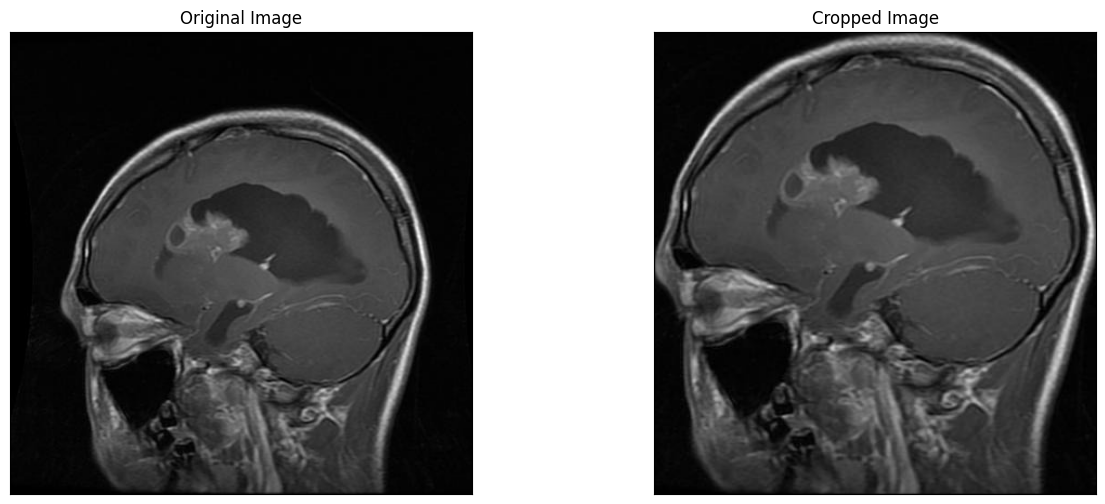

In [ ]:
example_image = cv2.imread('/content/tumor_dataset/Brain-MRI/Training/glioma_tumor/gg (60).jpg')
cropped_image = crop_image(example_image,plot = True)

In [ ]:

glioma = train_dir + 'glioma_tumor'
meningioma = train_dir + 'meningioma_tumor'
pituitary = train_dir + 'pituitary_tumor'
no_tumor = train_dir + 'no_tumor'

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 501/501 [00:02<00:00, 197.00it/s]


In [ ]:
test_glioma = test_dir + 'glioma_tumor'
test_meningioma = test_dir + 'meningioma_tumor'
test_pituitary = test_dir + 'pituitary_tumor'
test_no_tumor = test_dir + 'no_tumor'

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 5/5 [00:00<00:00, 155.07it/s]


In [ ]:
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)
train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')
valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Data/',
                                         target_size=(240, 240),
                                        class_mode='categorical',
                                        shuffle=False)


Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [ ]:
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import layers

In [ ]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

NUM_CLASSES = 4

model = Sequential()
model.add(vgg16_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_9 (Dropout)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14815044 (56.51 MB)
Trainable params: 100356 (392.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('content/drive/vgg16_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [ ]:
%%time

history = model.fit(train_data,
                    epochs = 10,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/10
82/82 [==============================] - ETA: 0s - loss: 8.8289 - accuracy: 0.6399 
Epoch 1: val_accuracy improved from -inf to 0.76534, saving model to content/drive/vgg16_model.h5
82/82 [==============================] - 2138s 26s/step - loss: 8.8289 - accuracy: 0.6399 - val_loss: 5.3483 - val_accuracy: 0.7653 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
82/82 [==============================] - ETA: 0s - loss: 6.3743 - accuracy: 0.7547 
Epoch 2: val_accuracy improved from 0.76534 to 0.78528, saving model to content/drive/vgg16_model.h5
82/82 [==============================] - 2073s 25s/step - loss: 6.3743 - accuracy: 0.7547 - val_loss: 6.2021 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 3/10
82/82 [==============================] - ETA: 0s - loss: 5.6938 - accuracy: 0.7941 
Epoch 3: val_accuracy improved from 0.78528 to 0.83282, saving model to content/drive/vgg16_model.h5
82/82 [==============================] - 2083s 25s/step - loss: 5.6938 - accuracy: 0.7941 - val_loss: 4.2142 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 4/10
82/82 [==============================] - ETA: 0s - loss: 4.9264 - accuracy: 0.8285 
Epoch 4: val_accuracy improved from 0.83282 to 0.83896, saving model to content/drive/vgg16_model.h5
82/82 [==============================] - 2078s 25s/step - loss: 4.9264 - accuracy: 0.8285 - val_loss: 4.5066 - val_accurac

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/vgg16_model.keras')

In [ ]:
import matplotlib.pyplot as plt

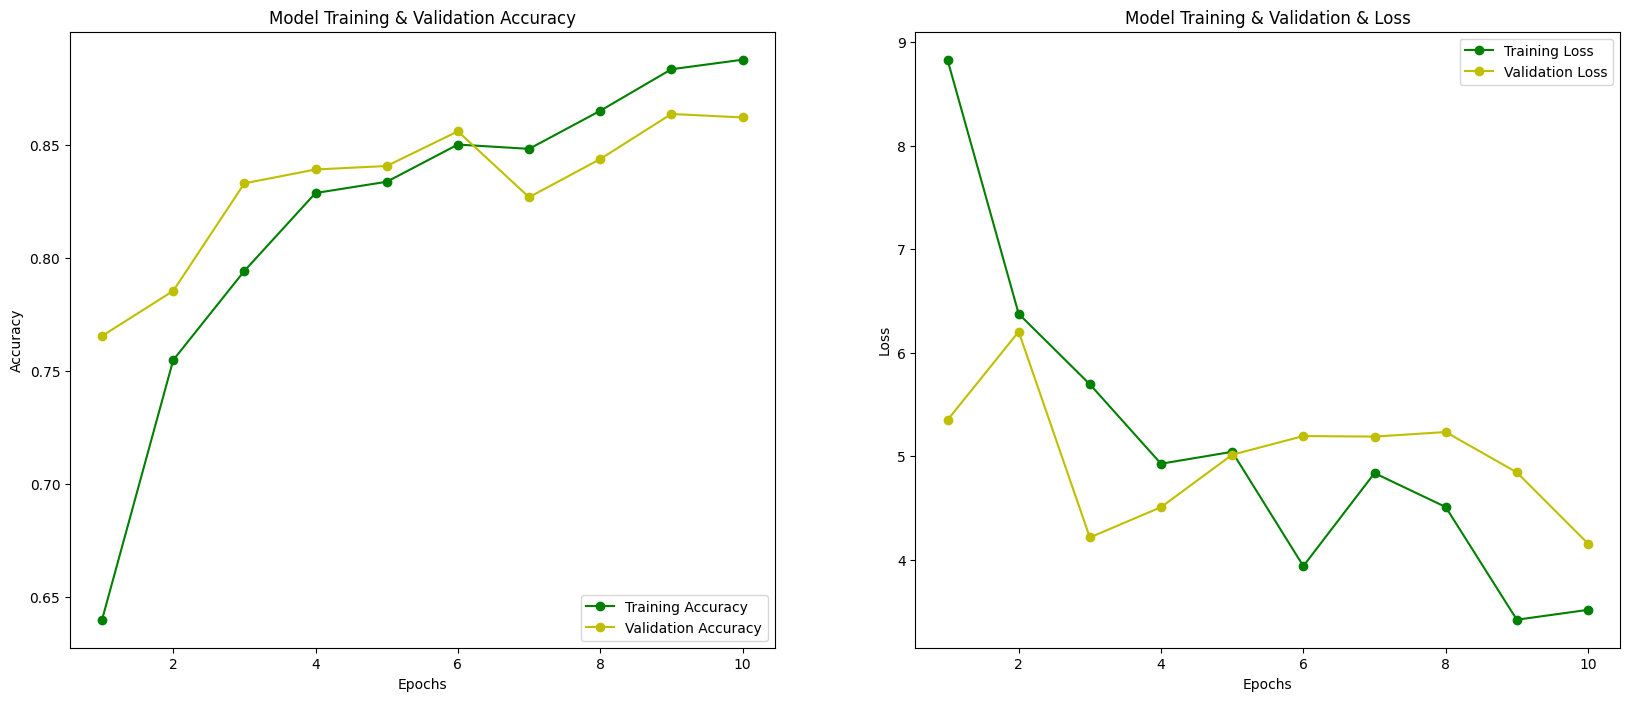

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/vgg16_model.keras')


In [ ]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

82/82 [==============================] - 1859s 23s/step - loss: 1.7738 - accuracy: 0.9296
Train accuracy & loss: [1.7737571001052856, 0.9295828342437744]


1/1 [==============================] - 14s 14s/step - loss: 0.1871 - accuracy: 0.9500
Test accuracy & loss: [0.1871289610862732, 0.949999988079071]


In [ ]:
y_test = test_data.classes

yhat_test = np.argmax(model.predict(test_data), axis=1)


1/1 [==============================] - 14s 14s/step


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


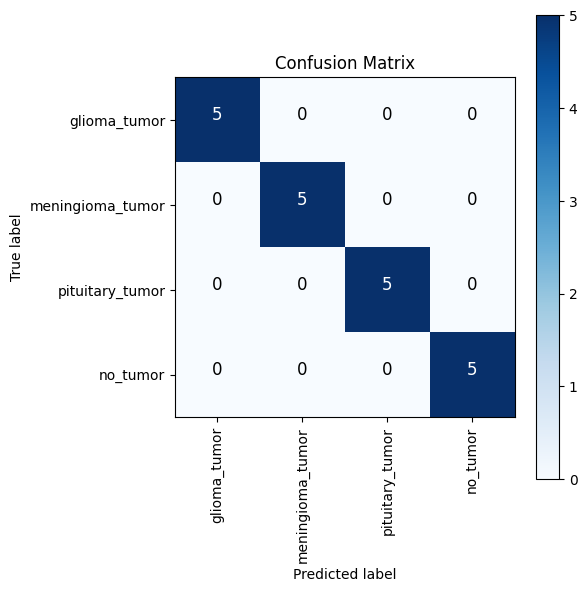

In [ ]:
cm = confusion_matrix(y_test, yhat_test)
print(cm)

plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

